In [1]:
import random
random.seed(0)
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from lifelines import CoxPHFitter
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from lifelines.statistics import proportional_hazard_test
warnings.filterwarnings('ignore')

Reading the dataset

In [2]:
original_data = pd.read_csv('Book1.csv')
original_data = original_data.drop(['p1','p2','p3','p4','p5','s1','s2','s3','s4','s5','c1','c2','c3','c4','c5','e1','e2','e3','e4','e5'], axis=1)

scores = pd.read_csv('factors.csv')
original_data = original_data.join(scores)
original_data.head(2)

,gender,age,f-edu,m-edu,income,event,duration,Economic factor,Course factor,Personal factor,Social factor
0,Male,22,College,High School,"21,194 - 43,828",1,31,-1.710816,-1.775135,-0.585477,-1.871831
1,Male,23,College,College,"43,828 - 76,669",0,40,1.635023,1.042365,0.632092,-0.452367


Data encoding

In [3]:
education = ['No formal education', 'Elementary', 'High School', 'College', 'Masters', 'PHd']
income = ['Less than  9,520', ' 9,520 to  21,194', ' 21,194 -  43,828', ' 43,828 -  76,669', ' 76,669 -  131,484', ' 131,484 -  219,140', ' 219,140 and up']
gender = ['Female', 'Male']

oe = OrdinalEncoder(categories=[education, education, income, gender])
le = LabelEncoder()

event = pd.DataFrame(le.fit_transform(original_data['event']), columns=['event'])
education_and_income = pd.DataFrame(oe.fit_transform(original_data[['f-edu', 'm-edu', 'income', 'gender']]), columns=['F-edu', 'M-edu', 'Income', 'Gender'])

In [4]:
df = original_data.drop(['gender', 'f-edu', 'm-edu', 'income', 'event'], axis=1)
df = df.join(event)
df = df.join(education_and_income)
df.head()

,age,duration,Economic factor,Course factor,Personal factor,Social factor,event,F-edu,M-edu,Income,Gender
0,22,31,-1.710816,-1.775135,-0.585477,-1.871831,1,3.0,2.0,2.0,1.0
1,23,40,1.635023,1.042365,0.632092,-0.452367,0,3.0,3.0,3.0,1.0
2,19,15,1.778198,-2.575687,-1.160066,-1.963175,1,3.0,2.0,3.0,1.0
3,24,40,-0.432404,-0.522861,-0.219047,0.873562,0,2.0,1.0,2.0,1.0
4,19,4,-1.416758,-1.647373,-0.362531,-0.878253,1,2.0,3.0,2.0,1.0


Fitting the model

In [5]:
model = CoxPHFitter()
model.fit(df, 'duration', 'event')
model.print_summary(model="Cox regression", decimals=3)

<lifelines.CoxPHFitter: fitted with 367 total observations, 304 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 367
number of events observed = 63
   partial log-likelihood = -312.555
         time fit was run = 2022-06-08 14:03:24 UTC
                    model = Cox regression

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age              0.011      1.011      0.072           -0.129            0.151                0.879                1.163
Economic factor -0.892      0.410      0.146           -1.179           -0.606                0.308                0.546
Course factor   -0.166      0.847      0.140           -0.441            0.108                0.644                1.114
Personal factor -0.158      0.854      0.141           -0.435            0.119                0.647                1.126
Social factor   -0.398      0.672      0.151           -0.694           -0.101                0.499                0.904
F-edu            0.319      1.375      0.197           -0.067            0.704                0.935                2.023
M-edu           -0.289      0.749      0.193           -0.667            0.088                0.513                1.092
Income           0.032      1.033      0.152           -0.265            0.329                0.767                1.390
Gender           0.640      1.897      0.278            0.095            1.186                1.099                3.273

                  cmp to      z       p   -log2(p)
covariate                                         
age                0.000  0.152   0.879      0.186
Economic factor    0.000 -6.107 <0.0005     29.874
Course factor      0.000 -1.190   0.234      2.094
Personal factor    0.000 -1.119   0.263      1.927
Social factor      0.000 -2.630   0.009      6.874
F-edu              0.000  1.620   0.105      3.249
M-edu              0.000 -1.502   0.133      2.909
Income             0.000  0.212   0.832      0.265
Gender             0.000  2.300   0.021      5.542
---
Concordance = 0.821
Partial AIC = 643.110
log-likelihood ratio test = 107.661 on 9 df
-log2(p) of ll-ratio test = 60.979

Measure of the model fit

In [6]:
results = model.log_likelihood_ratio_test()
results

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 9
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         107.66 <0.005     60.98

In [7]:
model.concordance_index_

0.8213386537456653

Looking at the functions

In [8]:
survival_function = model.baseline_survival_ # survival function
survival_function.to_csv('survival function.csv')
survival_function

,baseline survival
2.0,0.998985
3.0,0.996925
4.0,0.994862
5.0,0.992665
6.0,0.990464
7.0,0.988157
8.0,0.983257
9.0,0.980696
10.0,0.978087
11.0,0.976773


Text(0.5, 0, 'Duration (weeks)')

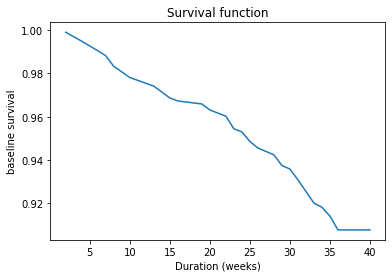

In [9]:
sns.lineplot(survival_function.index, survival_function['baseline survival'])
plt.title('Survival function')
plt.xlabel('Duration (weeks)')

In [10]:
baseline_cumhaz = model.baseline_cumulative_hazard_ #cummulative hazard
baseline_cumhaz.to_csv('baseline cumhazard.csv')
baseline_cumhaz

,baseline cumulative hazard
2.0,0.001016
3.0,0.003080
4.0,0.005152
5.0,0.007362
6.0,0.009582
7.0,0.011913
8.0,0.016885
9.0,0.019493
10.0,0.022156
11.0,0.023501


Text(0.5, 0, 'Duration (weeks)')

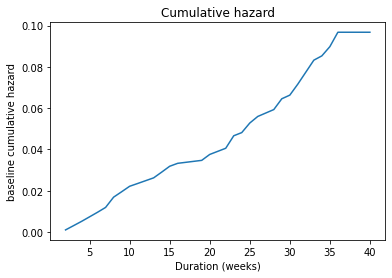

In [11]:
sns.lineplot(baseline_cumhaz.index, baseline_cumhaz['baseline cumulative hazard'])
plt.title('Cumulative hazard')
plt.xlabel('Duration (weeks)')

In [12]:
hazard_rate = model.baseline_hazard_ # hazard rate
hazard_rate.to_csv('hazard rate.csv')
hazard_rate

,baseline hazard
2.0,0.001016
3.0,0.002064
4.0,0.002071
5.0,0.002210
6.0,0.002220
7.0,0.002331
8.0,0.004972
9.0,0.002608
10.0,0.002664
11.0,0.001345


Text(0.5, 0, 'Duration (weeks)')

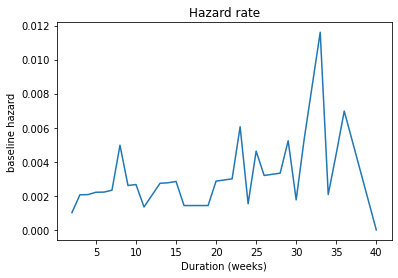

In [13]:
sns.lineplot(hazard_rate.index, hazard_rate['baseline hazard'])
plt.title('Hazard rate')
plt.xlabel('Duration (weeks)')

Text(0.5, 0, 'Duration (weeks)')

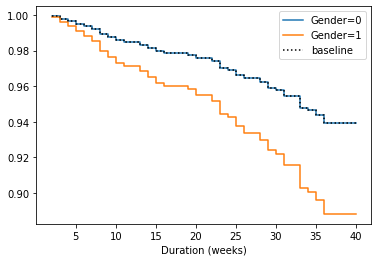

In [14]:
model.plot_partial_effects_on_outcome('Gender', [0, 1])
plt.xlabel('Duration (weeks)')

Text(0.5, 0, 'Duration (weeks)')

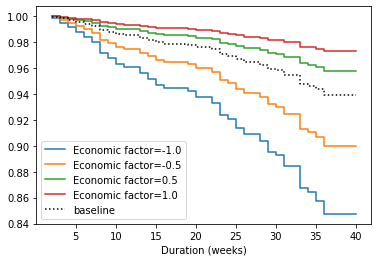

In [15]:
model.plot_covariate_groups('Economic factor', values=[-1, -0.5, .5, 1])
plt.xlabel('Duration (weeks)')


Text(0.5, 0, 'Duration (weeks)')

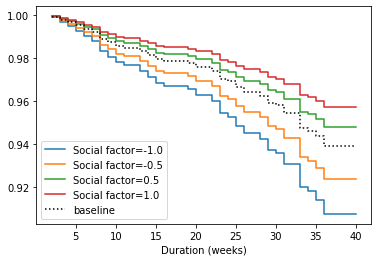

In [16]:
model.plot_covariate_groups('Social factor', values=[-1, -0.5, .5, 1])
plt.xlabel('Duration (weeks)')


<AxesSubplot:>

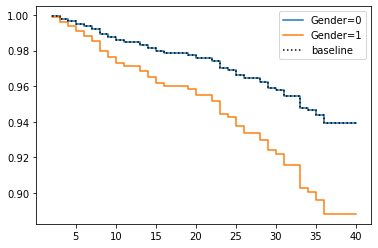

In [17]:
model.plot_covariate_groups('Gender', [0, 1])

In [18]:
res = model.check_assumptions(
    df, 
    p_value_threshold=0.05, 
    show_plots=True, 
    advice=True
)

res

Proportional hazard assumption looks okay.


[]

In [19]:
results = proportional_hazard_test(model, df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 367 total observations, 304 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic    p  -log2(p)
Course factor              0.69 0.41      1.30
Economic factor            0.04 0.84      0.26
F-edu                      0.23 0.63      0.66
Gender                     3.51 0.06      4.03
Income                     0.96 0.33      1.61
M-edu                      0.08 0.78      0.37
Personal factor            0.01 0.91      0.14
Social factor              0.00 0.98      0.02
age                        0.59 0.44      1.18

In [20]:
from bioinfokit.analys import stat

ctab = pd.crosstab(df.Gender, df.event)

res = stat()

res.chisq(df=ctab)

chi_square_test_res = pd.DataFrame(
    [
        [1,18.298,'<0.001'],
        [1,18.119,'<0.001']
    ],
    columns=['df', 'Chi-square', 'p'],
    index = ['Pearson','Log-likelihood']
)

chi_square_test_res.to_csv('Chi square result.csv')
chi_square_test_res


,df,Chi-square,p
Pearson,1,18.298,<0.001
Log-likelihood,1,18.119,<0.001


In [21]:
x = [[i] for i in range(400)]
y = [0 for i in range(400)]

In [22]:
s_resid = model.compute_residuals(df, 'scaled_schoenfeld')
s_resid

covariate,age,Economic factor,Course factor,Personal factor,Social factor,F-edu,M-edu,Income,Gender
14,1.099556,-0.785489,-1.198894,1.000474,-0.736399,-0.077610,0.205388,0.161104,-3.958498
6,0.459499,-0.110448,-0.087127,0.417107,0.569819,0.765000,-1.793340,0.268105,-3.159376
188,1.171537,2.544836,-0.727459,2.013060,0.176796,0.705613,1.516006,-2.612721,1.692673
4,-0.749678,-0.623516,-0.621807,0.769426,0.455543,-2.479171,2.847922,1.318443,2.339377
149,-0.206279,-1.283177,-0.838815,0.077530,0.252703,2.549150,-3.026425,1.362560,1.145273
...,...,...,...,...,...,...,...,...,...
140,-0.889180,-0.753876,0.962078,-0.668376,-0.049155,0.997768,-1.254071,-0.704238,1.970934
168,-1.209707,0.031938,0.153217,-1.468498,0.641122,1.045220,-1.671246,-0.828288,2.068460
81,0.152730,-1.728668,1.223333,-0.945370,0.042578,-0.934975,-0.553014,0.337318,1.268268
246,0.822471,-1.736484,0.072338,0.720949,0.325259,0.290394,-1.910354,2.239633,1.441947


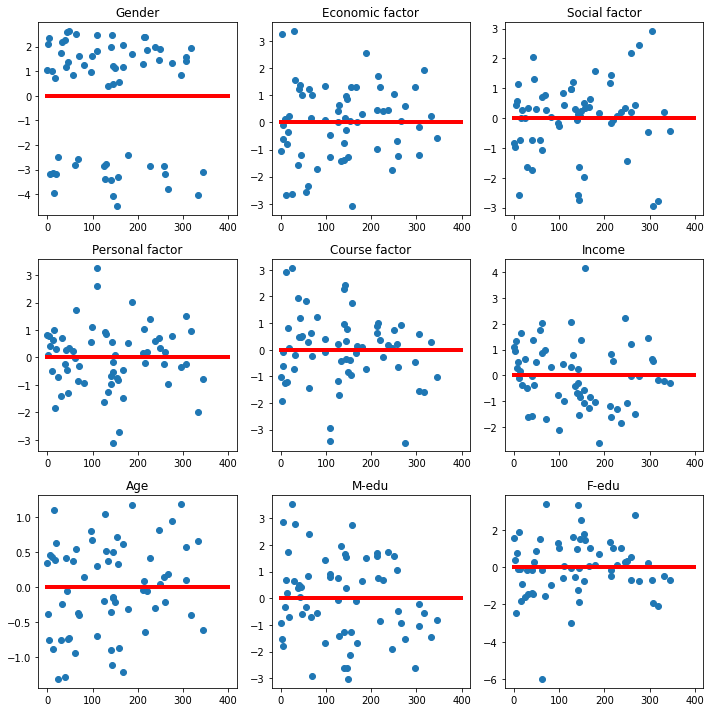

In [23]:
fig, ax = plt.subplots(3,3, figsize=(10,10))

ax[0, 0].scatter(s_resid.index, s_resid[['Gender']])
ax[0, 0].plot(x, y, color='r', linewidth=4)
ax[0, 0].set_title('Gender')

ax[0, 1].scatter(s_resid.index, s_resid[['Economic factor']])
ax[0, 1].plot(x, y, color='r', linewidth=4)
ax[0, 1].set_title('Economic factor')

ax[0, 2].scatter(s_resid.index, s_resid[['Social factor']])
ax[0, 2].plot(x, y, color='r', linewidth=4)
ax[0, 2].set_title('Social factor')

ax[1, 0].scatter(s_resid.index, s_resid[['Personal factor']])
ax[1, 0].plot(x, y, color='r', linewidth=4)
ax[1, 0].set_title('Personal factor')

ax[1, 1].scatter(s_resid.index, s_resid[['Course factor']])
ax[1, 1].plot(x, y, color='r', linewidth=4)
ax[1, 1].set_title('Course factor')

ax[1, 2].scatter(s_resid.index, s_resid[['Income']])
ax[1, 2].plot(x, y, color='r', linewidth=4)
ax[1, 2].set_title('Income')

ax[2, 0].scatter(s_resid.index, s_resid[['age']])
ax[2, 0].plot(x, y, color='r', linewidth=4)
ax[2, 0].set_title('Age')

ax[2, 1].scatter(s_resid.index, s_resid[['M-edu']])
ax[2, 1].plot(x, y, color='r', linewidth=4)
ax[2, 1].set_title('M-edu')

ax[2, 2].scatter(s_resid.index, s_resid[['F-edu']])
ax[2, 2].plot(x, y, color='r', linewidth=4)
ax[2, 2].set_title('F-edu')
fig.tight_layout()